In [1]:
# Install necessary packages
!pip install pandas numpy matplotlib seaborn scikit-learn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder


In [3]:
# Load the datasets
train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")
pincodes_data = pd.read_csv("./pincodes.csv", low_memory=False)


In [4]:
# Explore training data
print("=== Training Data Head ===")
print(train_data.head(), "\n")

# Explore testing data
print("=== Testing Data Head ===")
print(test_data.head(), "\n")

# Explore pincodes data
print("=== Pincodes Data Head ===")
print(pincodes_data.head(), "\n")


=== Training Data Head ===
          id order_delivered_date  courier_partner_id order_shipped_date  \
0  349197554           2022-06-05                   9         2022-06-02   
1  349197557           2022-06-04                   9         2022-06-02   
2  349197560           2022-06-07                   9         2022-06-02   
3  349197565           2022-06-05                   9         2022-06-02   
4  349197568           2022-06-07                   9         2022-06-02   

   account_type_id  drop_pin_code  pickup_pin_code  quantity account_mode  \
0             2471         141007           421311         1          Air   
1             2471         411047           421311         1          Air   
2             2471         145029           421311         1          Air   
3             2471         751015           562123         1          Air   
4             2471         145029           421311         1          Air   

   order_delivery_sla  
0                   3  
1    

In [5]:
# Convert date columns to datetime
train_data['order_shipped_date'] = pd.to_datetime(train_data['order_shipped_date'])
train_data['order_delivered_date'] = pd.to_datetime(train_data['order_delivered_date'])
test_data['order_shipped_date'] = pd.to_datetime(test_data['order_shipped_date'])

# Feature engineering: calculate actual SLA in training set
train_data['actual_sla'] = (train_data['order_delivered_date'] - train_data['order_shipped_date']).dt.days


In [6]:
# Encode categorical variables
categorical_cols = ['courier_partner_id', 'account_type_id', 'account_mode']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()

    # Fit the LabelEncoder on train data
    train_data[col] = le.fit_transform(train_data[col])
    label_encoders[col] = le

    # Transform test data, handling unseen labels
    test_data[col] = test_data[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)


In [7]:
# Feature selection
features = [
    'order_shipped_date', 'quantity', 'courier_partner_id',
    'account_type_id', 'drop_pin_code', 'pickup_pin_code', 'account_mode'
]
target = 'actual_sla'

# Convert dates into numerical values for the model
train_data['order_shipped_date'] = train_data['order_shipped_date'].astype(np.int64) // 10**9
test_data['order_shipped_date'] = pd.to_datetime(test_data['order_shipped_date']).astype(np.int64) // 10**9


In [8]:
# Split data for training and validation
X = train_data[features]
y = train_data[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Model training
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [10]:
# Model validation
y_pred = rf_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse}")

mae = mean_absolute_error(y_val, y_pred)
print(f'Validation MAE: {mae}')

r2 = r2_score(y_val, y_pred)
print(f'Validation R²: {r2}')


Validation RMSE: 0.7601252529590619
Validation MAE: 0.36453799423135036
Validation R²: 0.8074559915431081


In [11]:
# Feature importance
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importances)


              Feature  Importance
2  courier_partner_id    0.373501
4       drop_pin_code    0.366301
0  order_shipped_date    0.146914
5     pickup_pin_code    0.087783
6        account_mode    0.018469
3     account_type_id    0.007031
1            quantity    0.000000


In [12]:
# Test prediction
test_data['predicted_exact_sla'] = rf_model.predict(test_data[features])

# Save submission
submission = test_data[['id', 'predicted_exact_sla']]
submission.to_csv("submission.csv", index=False)

3

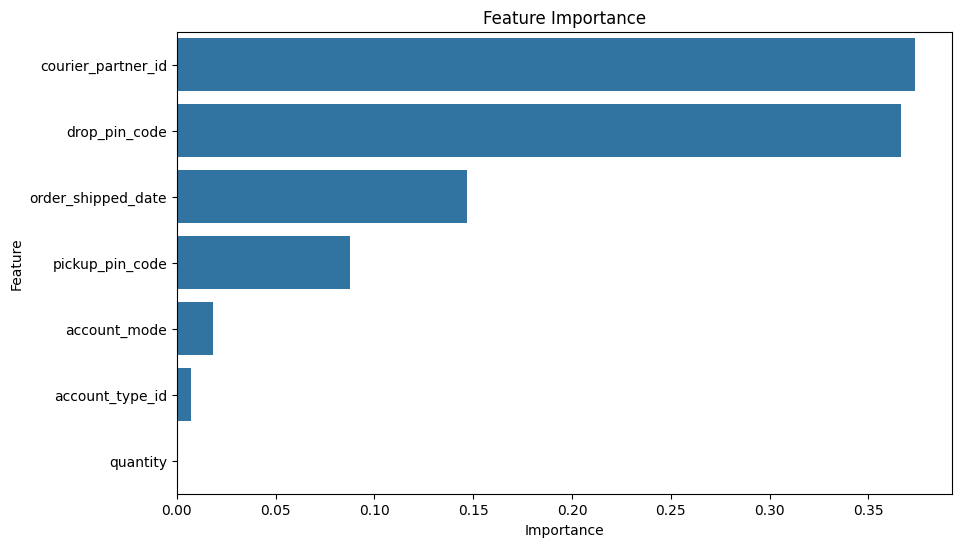

In [13]:
# Visualization of feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance')
plt.show()


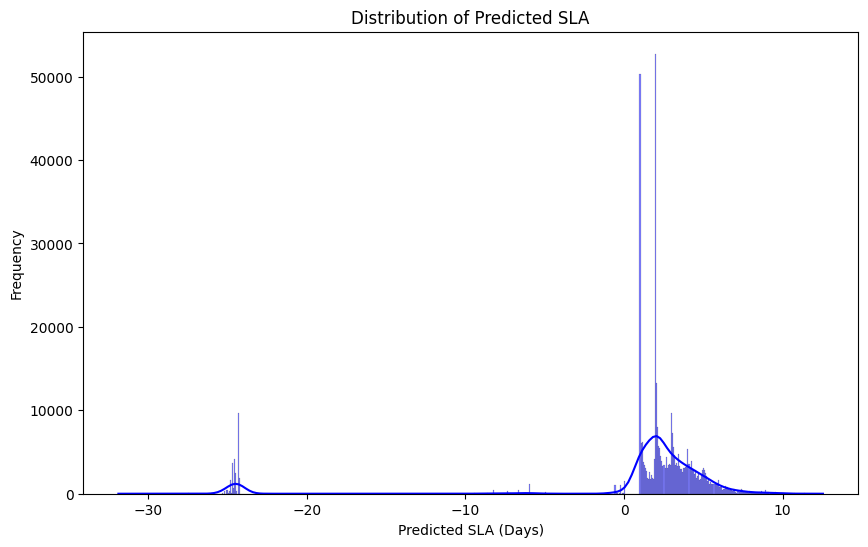

In [14]:
# Load submission.csv
predictions = pd.read_csv('submission.csv')

# Plot SLA distribution
plt.figure(figsize=(10, 6))
sns.histplot(predictions['predicted_exact_sla'], kde=True, color='blue')
plt.title('Distribution of Predicted SLA')
plt.xlabel('Predicted SLA (Days)')
plt.ylabel('Frequency')
plt.savefig('sla_distribution.png')
plt.show()


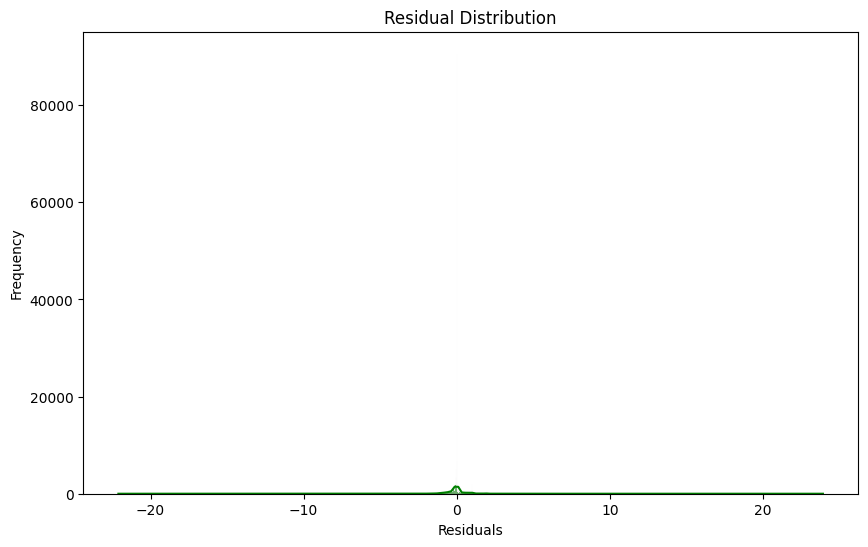

In [15]:
# Plot residuals
residuals = y_val - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='green')
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


In [16]:
# Import additional libraries for classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import KBinsDiscretizer

# Define the number of bins for classification (e.g., 3 categories)
n_bins = 3
enc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')

# Fit and transform the target variable for training and validation sets
y_train_binned = enc.fit_transform(y_train.values.reshape(-1, 1)).astype(int).ravel()
y_val_binned = enc.transform(y_val.values.reshape(-1, 1)).astype(int).ravel()

# Predict using the regression model
y_val_pred_reg = rf_model.predict(X_val)

# Convert regression predictions to binned classes
y_val_pred_binned = enc.transform(y_val_pred_reg.reshape(-1, 1)).astype(int).ravel()

# Calculate classification metrics
accuracy = accuracy_score(y_val_binned, y_val_pred_binned)
precision = precision_score(y_val_binned, y_val_pred_binned, average='weighted', zero_division=0)
recall = recall_score(y_val_binned, y_val_pred_binned, average='weighted', zero_division=0)

print(f"Classification Accuracy: {accuracy:.4f}")
print(f"Classification Precision: {precision:.4f}")
print(f"Classification Recall: {recall:.4f}")


Classification Accuracy: 0.9943
Classification Precision: 0.9938
Classification Recall: 0.9943


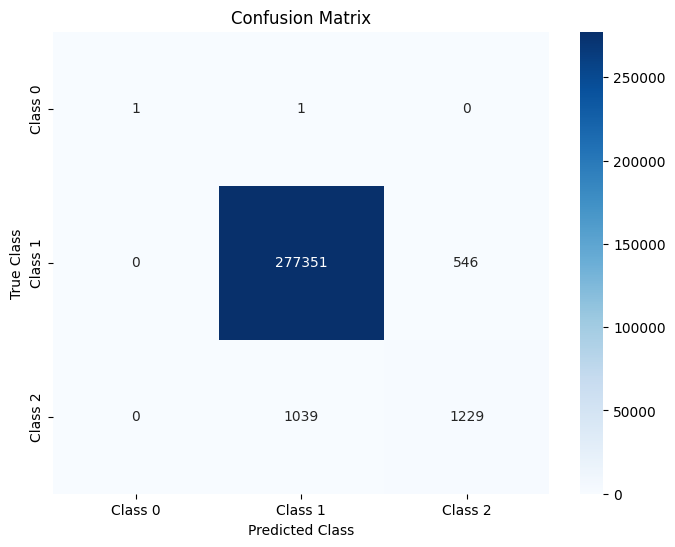

In [17]:
# Import additional libraries for visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_val_binned, y_val_pred_binned)

# Define class labels based on the number of bins
class_labels = [f"Class {i}" for i in range(n_bins)]

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


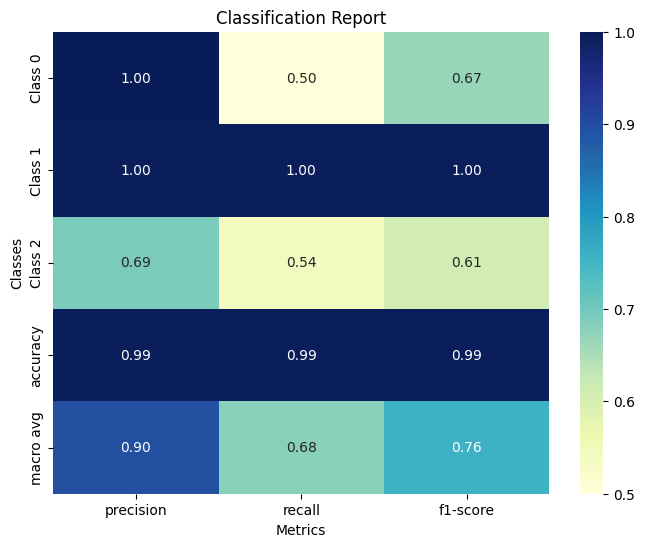

In [18]:
# Import additional libraries for visualization
from sklearn.metrics import classification_report
import pandas as pd

# Generate the classification report
report = classification_report(y_val_binned, y_val_pred_binned, target_names=class_labels, output_dict=True)

# Convert the report to a DataFrame for easier visualization
report_df = pd.DataFrame(report).transpose()

# Plot the classification report using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :3], annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Classification Report')
plt.ylabel('Classes')
plt.xlabel('Metrics')
plt.show()


<ipython-input-19-8705ac1323bc>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='True Class', data=binned_comparison, palette='viridis')
<ipython-input-19-8705ac1323bc>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Predicted Class', data=binned_comparison, palette='magma')


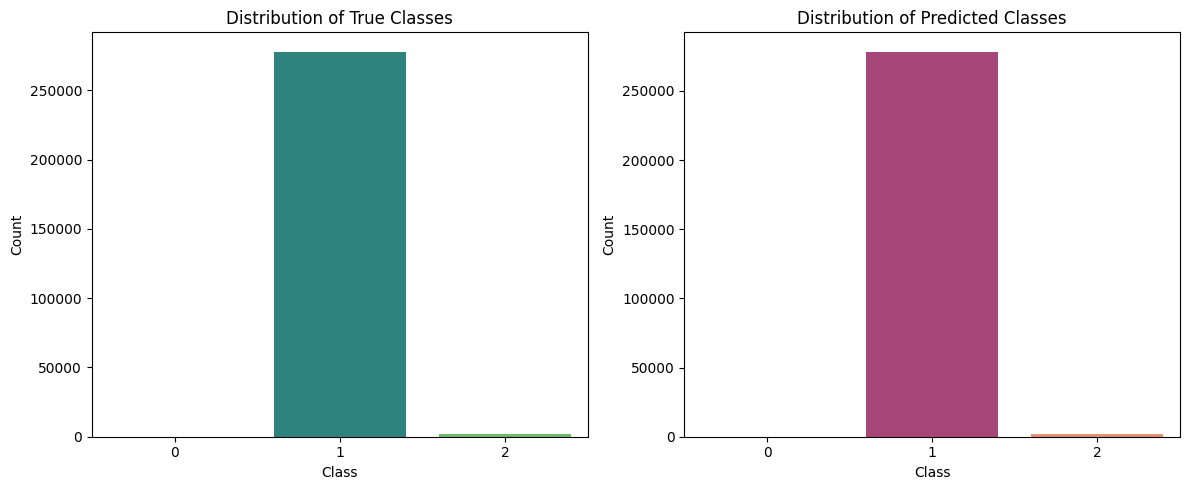

In [19]:
# Import additional libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for true and predicted binned labels
binned_comparison = pd.DataFrame({
    'True Class': y_val_binned,
    'Predicted Class': y_val_pred_binned
})

# Plot the distribution of true classes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='True Class', data=binned_comparison, palette='viridis')
plt.title('Distribution of True Classes')
plt.xlabel('Class')
plt.ylabel('Count')

# Plot the distribution of predicted classes
plt.subplot(1, 2, 2)
sns.countplot(x='Predicted Class', data=binned_comparison, palette='magma')
plt.title('Distribution of Predicted Classes')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


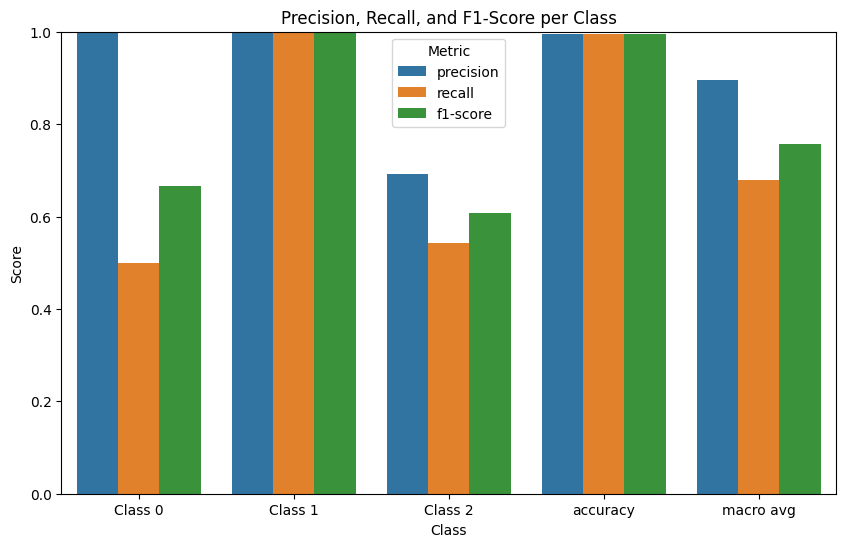

In [20]:
# Extract precision, recall, and f1-score from the classification report
metrics = report_df.iloc[:-1, :3].reset_index()
metrics = metrics.rename(columns={'index': 'Class'})

# Melt the DataFrame for easier plotting
metrics_melted = metrics.melt(id_vars='Class', value_vars=['precision', 'recall', 'f1-score'],
                              var_name='Metric', value_name='Score')

# Plot the metrics
plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Score', hue='Metric', data=metrics_melted)
plt.title('Precision, Recall, and F1-Score per Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim(0, 1)  # Since metrics range from 0 to 1
plt.legend(title='Metric')
plt.show()


<ipython-input-21-d4849ee8a82e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Score', data=comparison_metrics, palette='Set2')


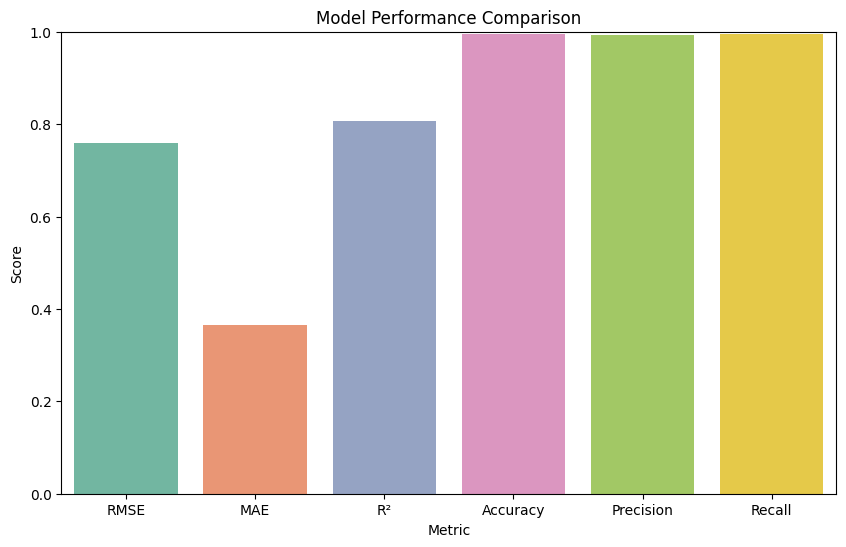

In [21]:
# Create a DataFrame for regression and classification metrics
comparison_metrics = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²', 'Accuracy', 'Precision', 'Recall'],
    'Score': [rmse, mae, r2, accuracy, precision, recall]
})

# Plot the comparison metrics
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', data=comparison_metrics, palette='Set2')
plt.title('Model Performance Comparison')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)  # Adjust if necessary based on RMSE and MAE
plt.show()
